In [42]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import math
import itertools 
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import scipy
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
import random
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, fbeta_score
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
from xgboost import XGBClassifier
from prettytable import PrettyTable
import re
import scipy.stats as ss
from tqdm import tqdm
import pickle
from tqdm import tqdm
import os


<h2>1.1 Loading Dataset <h2>

In [2]:
# Unrar the file

!unrar x "/content/dataset.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/dataset.rar

Extracting  Kaggle_Training_Dataset_v2.csv                                 0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87%  OK 
Extracting  Kaggle_Test_Dataset_v2.csv                                    87% 88% 89% 90%

In [3]:
# Read the csv file

df_train=pd.read_csv("/content/Kaggle_Training_Dataset_v2.csv")
df_test=pd.read_csv("/content/Kaggle_Test_Dataset_v2.csv")

In [4]:
df_train

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687856,1373987,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,8.0,0.0,No,0.0,-99.00,-99.00,1.0,No,No,No,Yes,No,No
1687857,1524346,-1.0,9.0,0.0,7.0,9.0,11.0,0.0,8.0,11.0,12.0,0.0,No,0.0,0.86,0.84,1.0,Yes,No,No,No,No,Yes
1687858,1439563,62.0,9.0,16.0,39.0,87.0,126.0,35.0,63.0,153.0,205.0,12.0,No,0.0,0.86,0.84,6.0,No,No,No,Yes,No,No
1687859,1502009,19.0,4.0,0.0,0.0,0.0,0.0,2.0,7.0,12.0,20.0,1.0,No,0.0,0.73,0.78,1.0,No,No,No,Yes,No,No


In [5]:
df_test

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,3285085,62.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
1,3285131,9.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,-99.00,-99.00,0.0,No,No,Yes,No,No,No
2,3285358,17.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.92,0.95,0.0,No,No,No,Yes,No,No
3,3285517,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,No,0.0,0.78,0.75,0.0,No,No,Yes,Yes,No,No
4,3285608,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.54,0.71,0.0,No,No,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242071,3526988,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242072,3526989,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242073,3526990,10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242074,3526991,2913.0,12.0,0.0,0.0,0.0,0.0,0.0,30.0,88.0,88.0,4.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No


### 1.2.5 Dropping the last record which contains NaN

In [6]:
df_train=df_train[:-1]
df_test=df_test[:-1]

##Utility Functions

In [7]:
#Function to plot confusion matrix

def plot_conf_matrix (conf_matrix, dtype):
    class_names = [0,1]
    fontsize=14
    df_conf_matrix = pd.DataFrame(
            conf_matrix, index=class_names, columns=class_names, 
        )
    fig = plt.figure()
    heatmap = sns.heatmap(df_conf_matrix, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix for {0}'.format(dtype))

def metric(y_prob,y_true,y_pred):
  f2= round(fbeta_score(y_cv,y_pred_cv, pos_label = 1,average='weighted', beta=2),2)
  roc_auc = roc_auc_score(y_cv, y_prob_cv)
  rs=round(recall_score(y_cv, y_pred_cv),2)
  average_precision = average_precision_score(y_cv, y_prob_cv)
  return f2,roc_auc,rs,average_precision



# Feature Engineering

## Converting  Boolean values to Binary values 

In [8]:
# Encode categorical columns with values Yes and No to 1 and 0 respectively

dict_map_bool={'Yes':1.0,'No':0.0}

#Train data
df_train['deck_risk']=df_train['deck_risk'].map(dict_map_bool)
df_train['potential_issue']=df_train['potential_issue'].map(dict_map_bool)
df_train['oe_constraint']=df_train['oe_constraint'].map(dict_map_bool)
df_train['ppap_risk']=df_train['ppap_risk'].map(dict_map_bool)
df_train['stop_auto_buy']=df_train['stop_auto_buy'].map(dict_map_bool)
df_train['rev_stop']=df_train['rev_stop'].map(dict_map_bool)
df_train['went_on_backorder']=df_train['went_on_backorder'].map(dict_map_bool)

#Test data
df_test['deck_risk']=df_test['deck_risk'].map(dict_map_bool)
df_test['potential_issue']=df_test['potential_issue'].map(dict_map_bool)
df_test['oe_constraint']=df_test['oe_constraint'].map(dict_map_bool)
df_test['ppap_risk']=df_test['ppap_risk'].map(dict_map_bool)
df_test['stop_auto_buy']=df_test['stop_auto_buy'].map(dict_map_bool)
df_test['rev_stop']=df_test['rev_stop'].map(dict_map_bool)
df_test['went_on_backorder']=df_test['went_on_backorder'].map(dict_map_bool)

In [9]:
df_train

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-99.00,-99.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99,0.99,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-99.00,-99.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.10,0.13,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,-99.00,-99.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687855,1407754,0.0,2.0,0.0,10.0,10.0,10.0,0.0,5.0,7.0,7.0,0.0,0.0,0.0,0.69,0.69,5.0,1.0,0.0,0.0,1.0,0.0,0.0
1687856,1373987,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,8.0,0.0,0.0,0.0,-99.00,-99.00,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1687857,1524346,-1.0,9.0,0.0,7.0,9.0,11.0,0.0,8.0,11.0,12.0,0.0,0.0,0.0,0.86,0.84,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1687858,1439563,62.0,9.0,16.0,39.0,87.0,126.0,35.0,63.0,153.0,205.0,12.0,0.0,0.0,0.86,0.84,6.0,0.0,0.0,0.0,1.0,0.0,0.0


In [10]:
df_test

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,3285085,62.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-99.00,-99.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,3285131,9.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-99.00,-99.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3285358,17.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.92,0.95,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3285517,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.78,0.75,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,3285608,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.54,0.71,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242070,3526987,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.48,0.48,0.0,1.0,0.0,0.0,1.0,0.0,0.0
242071,3526988,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.48,0.48,0.0,1.0,0.0,0.0,1.0,0.0,0.0
242072,3526989,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.48,0.48,0.0,1.0,0.0,0.0,1.0,0.0,0.0
242073,3526990,10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.48,0.48,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Replacing unknown values

In [11]:
#Replacing -99 in perfomance columns with nan

#Train data
df_train.perf_6_month_avg.replace({-99.0 : np.nan}, inplace = True)
df_train.perf_12_month_avg.replace({-99.0 : np.nan}, inplace = True)

#Test data
df_test.perf_6_month_avg.replace({-99.0 : np.nan}, inplace = True)
df_test.perf_12_month_avg.replace({-99.0 : np.nan}, inplace = True)

In [12]:
df_train

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99,0.99,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.10,0.13,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,NaN,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687855,1407754,0.0,2.0,0.0,10.0,10.0,10.0,0.0,5.0,7.0,7.0,0.0,0.0,0.0,0.69,0.69,5.0,1.0,0.0,0.0,1.0,0.0,0.0
1687856,1373987,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,8.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1687857,1524346,-1.0,9.0,0.0,7.0,9.0,11.0,0.0,8.0,11.0,12.0,0.0,0.0,0.0,0.86,0.84,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1687858,1439563,62.0,9.0,16.0,39.0,87.0,126.0,35.0,63.0,153.0,205.0,12.0,0.0,0.0,0.86,0.84,6.0,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
df_test

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,3285085,62.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,3285131,9.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3285358,17.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.92,0.95,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3285517,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.78,0.75,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,3285608,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.54,0.71,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242070,3526987,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.48,0.48,0.0,1.0,0.0,0.0,1.0,0.0,0.0
242071,3526988,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.48,0.48,0.0,1.0,0.0,0.0,1.0,0.0,0.0
242072,3526989,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.48,0.48,0.0,1.0,0.0,0.0,1.0,0.0,0.0
242073,3526990,10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.48,0.48,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687860 entries, 0 to 1687859
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   sku                1687860 non-null  object 
 1   national_inv       1687860 non-null  float64
 2   lead_time          1586967 non-null  float64
 3   in_transit_qty     1687860 non-null  float64
 4   forecast_3_month   1687860 non-null  float64
 5   forecast_6_month   1687860 non-null  float64
 6   forecast_9_month   1687860 non-null  float64
 7   sales_1_month      1687860 non-null  float64
 8   sales_3_month      1687860 non-null  float64
 9   sales_6_month      1687860 non-null  float64
 10  sales_9_month      1687860 non-null  float64
 11  min_bank           1687860 non-null  float64
 12  potential_issue    1687860 non-null  float64
 13  pieces_past_due    1687860 non-null  float64
 14  perf_6_month_avg   1558382 non-null  float64
 15  perf_12_month_avg  1565810 non-n

In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242075 entries, 0 to 242074
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   sku                242075 non-null  object 
 1   national_inv       242075 non-null  float64
 2   lead_time          227351 non-null  float64
 3   in_transit_qty     242075 non-null  float64
 4   forecast_3_month   242075 non-null  float64
 5   forecast_6_month   242075 non-null  float64
 6   forecast_9_month   242075 non-null  float64
 7   sales_1_month      242075 non-null  float64
 8   sales_3_month      242075 non-null  float64
 9   sales_6_month      242075 non-null  float64
 10  sales_9_month      242075 non-null  float64
 11  min_bank           242075 non-null  float64
 12  potential_issue    242075 non-null  float64
 13  pieces_past_due    242075 non-null  float64
 14  perf_6_month_avg   222974 non-null  float64
 15  perf_12_month_avg  224100 non-null  float64
 16  lo

# Handling missing values

In [16]:

X_train_iter = df_train.copy()
#X_cv_iter = X_cv.copy()
#X_test_iter = df_test.drop(['went_on_backorder'], axis=1)
X_test_iter= df_test.copy()
iter = IterativeImputer(max_iter=10, random_state=0)
iter.fit(X_train_iter)
X_train_iter[:] = iter.transform(X_train_iter)
#X_cv_iter[:] = iter.transform(X_cv_iter)
X_test_iter[:] = iter.transform(X_test_iter)

'''
##Simple Imputation
df_train['lead_time'] = SimpleImputer(strategy='median').fit_transform(df_train['lead_time'].values.reshape(-1, 1))
df_test.lead_time.replace(to_replace = np.nan, value =np.median(df_test.lead_time), inplace=True)

for col in ['perf_6_month_avg', 'perf_12_month_avg']:
    df_train[col] = SimpleImputer(missing_values=-99, strategy='median').fit_transform(df_train[col].values.reshape(-1, 1))
    df_test[col].replace(to_replace = -99, value =np.median(df[col]), inplace=True)

X_train_si=df_train.copy()
X_test_si=df_test.copy()
'''

"\n##Simple Imputation\ndf_train['lead_time'] = SimpleImputer(strategy='median').fit_transform(df_train['lead_time'].values.reshape(-1, 1))\ndf_test.lead_time.replace(to_replace = np.nan, value =np.median(df_test.lead_time), inplace=True)\n\nfor col in ['perf_6_month_avg', 'perf_12_month_avg']:\n    df_train[col] = SimpleImputer(missing_values=-99, strategy='median').fit_transform(df_train[col].values.reshape(-1, 1))\n    df_test[col].replace(to_replace = -99, value =np.median(df[col]), inplace=True)\n\nX_train_si=df_train.copy()\nX_test_si=df_test.copy()\n"

In [17]:
#Numerical columns list
num_col_list=['national_inv','lead_time','in_transit_qty','forecast_3_month','forecast_6_month','forecast_9_month','sales_1_month','sales_3_month','sales_6_month','sales_9_month','min_bank','pieces_past_due','perf_6_month_avg','perf_12_month_avg','local_bo_qty']

##Raw Data features Visualization Before Transformations

In [18]:
df_train_num_untrans=df_train.copy()
df_train_num_untrans=df_train_num_untrans.drop(['sku','potential_issue','deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop' ], axis=1)

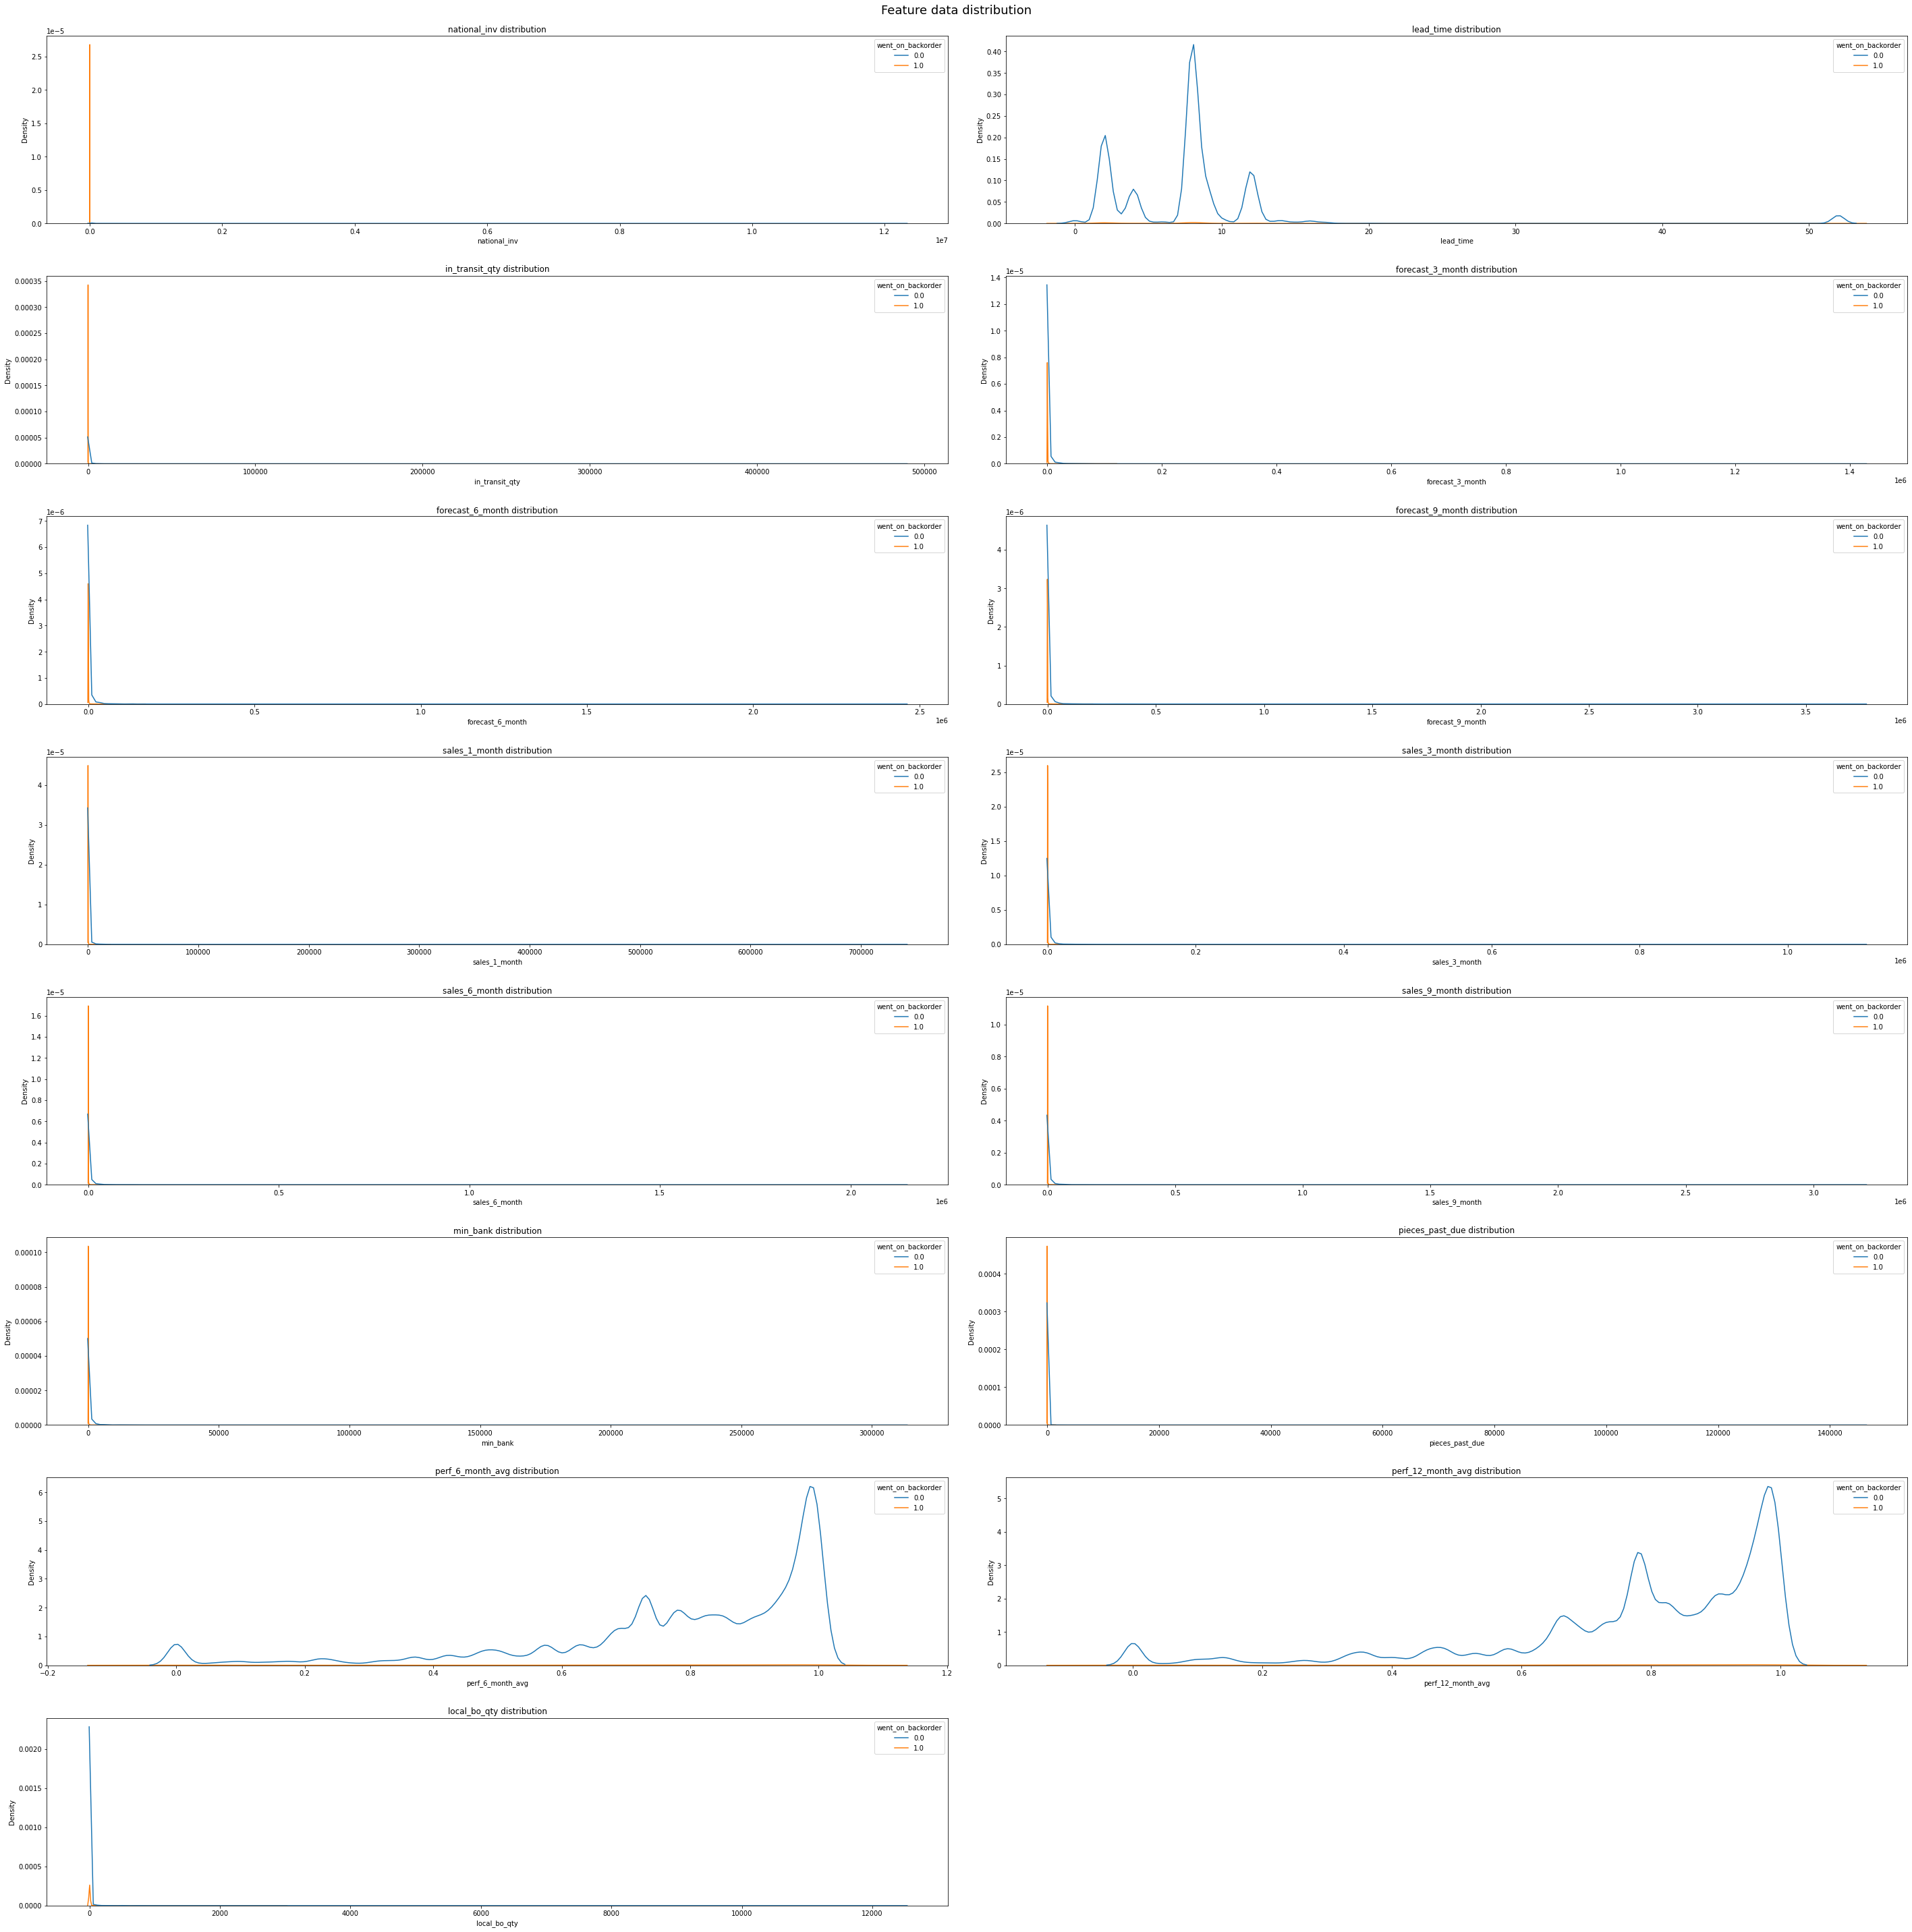

In [19]:
#Distribution of features before transformations

fig = plt.figure(figsize=(40,40))
for idx, val in enumerate(df_train_num_untrans.drop(['went_on_backorder'], axis=1)):
  ax1=fig.add_subplot(8, 2, idx+1)
  ax1.title.set_text(val+' distribution')
  sns.kdeplot(data = df_train_num_untrans, x=val, hue='went_on_backorder')
fig.tight_layout(pad=3.0)
fig.suptitle("Feature data distribution", fontsize=18, y=1, x=.5)
plt.show()

##Transformed Features Visualization

In [20]:
X_train_iter_stand=X_train_iter.copy()
X_test_iter_stand=X_test_iter.copy()

In [21]:
#Applying Standard Scaler
sc = StandardScaler().fit(X_train_iter_stand[num_col_list].values)
X_tr_sc_num_feat=sc.transform(X_train_iter_stand[num_col_list].values)
X_te_sc_num_feat=sc.transform(X_test_iter_stand[num_col_list].values)

X_tr_sc_num_feat = pd.DataFrame(X_tr_sc_num_feat, index=X_train_iter_stand.index, columns=num_col_list)
X_te_sc_num_feat = pd.DataFrame(X_te_sc_num_feat, index=X_test_iter_stand.index, columns=num_col_list)

In [22]:
#Assigning numerical columns to original dataframe

for i in num_col_list:
  X_train_iter_stand[i]=X_tr_sc_num_feat[i]
  X_test_iter_stand[i]=X_te_sc_num_feat[i]

In [23]:
##Random Undersample the dataset to balance the data
y_train=df_train['went_on_backorder']
undersample = RandomUnderSampler()
X_train_iter_under, y_train_iter_under = undersample.fit_resample(X_train_iter_stand, y_train)

In [24]:
#Creating undersampled dataframes for train set
X_train_iter_under=pd.DataFrame(X_train_iter_under, columns=X_train_iter_stand.columns)
y_train_iter_under=pd.DataFrame(y_train_iter_under,columns=['went_on_backorder'])

In [25]:
#Creating dataframes with numerical features for train and test set

X_train_iter_under_num=X_train_iter_under.drop(columns=['sku','potential_issue','deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop'],axis=1)
X_test_iter_num=X_test_iter_stand.drop(columns=['sku','potential_issue','deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop'],axis=1)

In [26]:
X_train_iter_under_num

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,went_on_backorder
0,-0.016549,-0.723480,-0.032808,-0.035436,-0.035220,-0.035216,-0.028486,-0.033130,-0.034300,-0.034118,-0.042050,-0.008659,0.911005,0.962416,-0.018577,0.0
1,-0.016482,-0.010192,-0.032808,-0.035436,-0.035220,-0.035077,-0.029004,-0.033708,-0.035548,-0.035399,-0.042050,-0.008659,0.954393,1.007454,-0.018577,0.0
2,-0.003954,-0.866138,-0.014189,0.044142,0.026035,0.020421,0.006262,0.009047,0.017608,0.025389,0.149984,-0.008659,0.954393,1.007454,-0.018577,0.0
3,-0.016617,0.560438,-0.032808,-0.035436,-0.035220,-0.035216,-0.029004,-0.033708,-0.035548,-0.035399,-0.042050,-0.008659,0.086645,-0.028405,-0.018577,0.0
4,-0.014591,-0.866138,0.020814,-0.035436,-0.035220,-0.035216,-0.018113,-0.024657,-0.029931,-0.031760,-0.035676,-0.008659,0.043257,0.241819,-0.018577,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22581,-0.016752,-0.010192,-0.032808,-0.030462,-0.032668,-0.033477,-0.029004,-0.031975,-0.033468,-0.033444,-0.031692,-0.008659,0.737456,0.827304,0.011077,1.0
22582,-0.016988,-0.010192,-0.032808,-0.016337,-0.025419,-0.025201,-0.022781,-0.025042,-0.027850,-0.029199,-0.042050,-0.008659,0.737456,0.286856,0.189001,1.0
22583,-0.019926,-0.010192,-0.014189,0.120934,0.089944,0.082804,0.128656,0.054305,0.040494,0.037721,0.102175,-0.008659,-1.475301,-0.703965,3.717831,1.0
22584,-0.016752,-0.866138,-0.032808,0.376576,0.273606,0.202076,-0.026930,0.113431,0.043926,0.016156,0.481463,-0.008659,0.867618,0.962416,0.100039,1.0


##Creating New features

In [27]:
#Function to fit logistic regression model
def model(df_final,y):
  log_reg = LogisticRegression()
  log_reg.fit(df_final, y)
  return log_reg

  
#Function to perform addition of features  
def add(df,num_cols):
  for i in num_cols:
    for j in num_cols:
      if (i!=j):
        df[i+'_'+j+'_add']=df[i]+df[j]
  return df
  
#Function to perform multiplication of features
def mult(df,num_cols):
  for i in num_cols:
    for j in num_cols:
      if (i!=j):
        df[i+'_'+j+'_mult']=df[i]*df[j]
  return df
  

#Function to perform inverse of features
def inv(df,num_cols):
    for i in num_cols:
      df[i+'_'+'inv']=1/(df[i]+0.001)

    return df

#Function to perform square of features
def square(df,num_cols):
  for i in num_cols:
    df[i+'_'+'square']=df[i] * df[i]
  return df

#Function to perform square root of features
def sqrt(df,num_cols):
  for i in num_cols:
    df[i+'_'+'square_root']=np.sqrt(abs(df[i]))
  return df

#Function to perform log of features
def log(df,num_cols):
  for i in num_cols:
    df[i+'_'+'log']= (np.log(abs(df[i])+1))
  return df

In [28]:
#Applying tranformed functions on train data
X_train_iter_trans=add(X_train_iter_under_num,num_col_list)
X_train_iter_trans=mult(X_train_iter_trans,num_col_list)
X_train_iter_trans=inv(X_train_iter_trans,num_col_list)
X_train_iter_trans=square(X_train_iter_trans,num_col_list)
X_train_iter_trans=sqrt(X_train_iter_trans,num_col_list)
X_train_iter_trans=log(X_train_iter_trans,num_col_list)

#Applying tranformed functions on test data
X_test_iter_trans=add(X_test_iter_num,num_col_list)
X_test_iter_trans=mult(X_test_iter_trans,num_col_list)
X_test_iter_trans=inv(X_test_iter_trans,num_col_list)
X_test_iter_trans=square(X_test_iter_trans,num_col_list)
X_test_iter_trans=sqrt(X_test_iter_trans,num_col_list)
X_test_iter_trans=log(X_test_iter_trans,num_col_list)

X_train_iter_trans=X_train_iter_trans.drop(['went_on_backorder'],axis=1)
X_test_iter_trans=X_test_iter_trans.drop(['went_on_backorder'],axis=1)

#applying logistic regression
model=model(X_train_iter_trans,y_train_iter_under)
importances = model.coef_
abs_imp=np.abs(importances[0])

#get the sorting indices
sorted_idx = (-abs_imp).argsort()


In [29]:
X_train_iter_trans_plt=X_train_iter_trans.copy()
X_train_iter_trans_plt['went_on_backorder']=y_train_iter_under

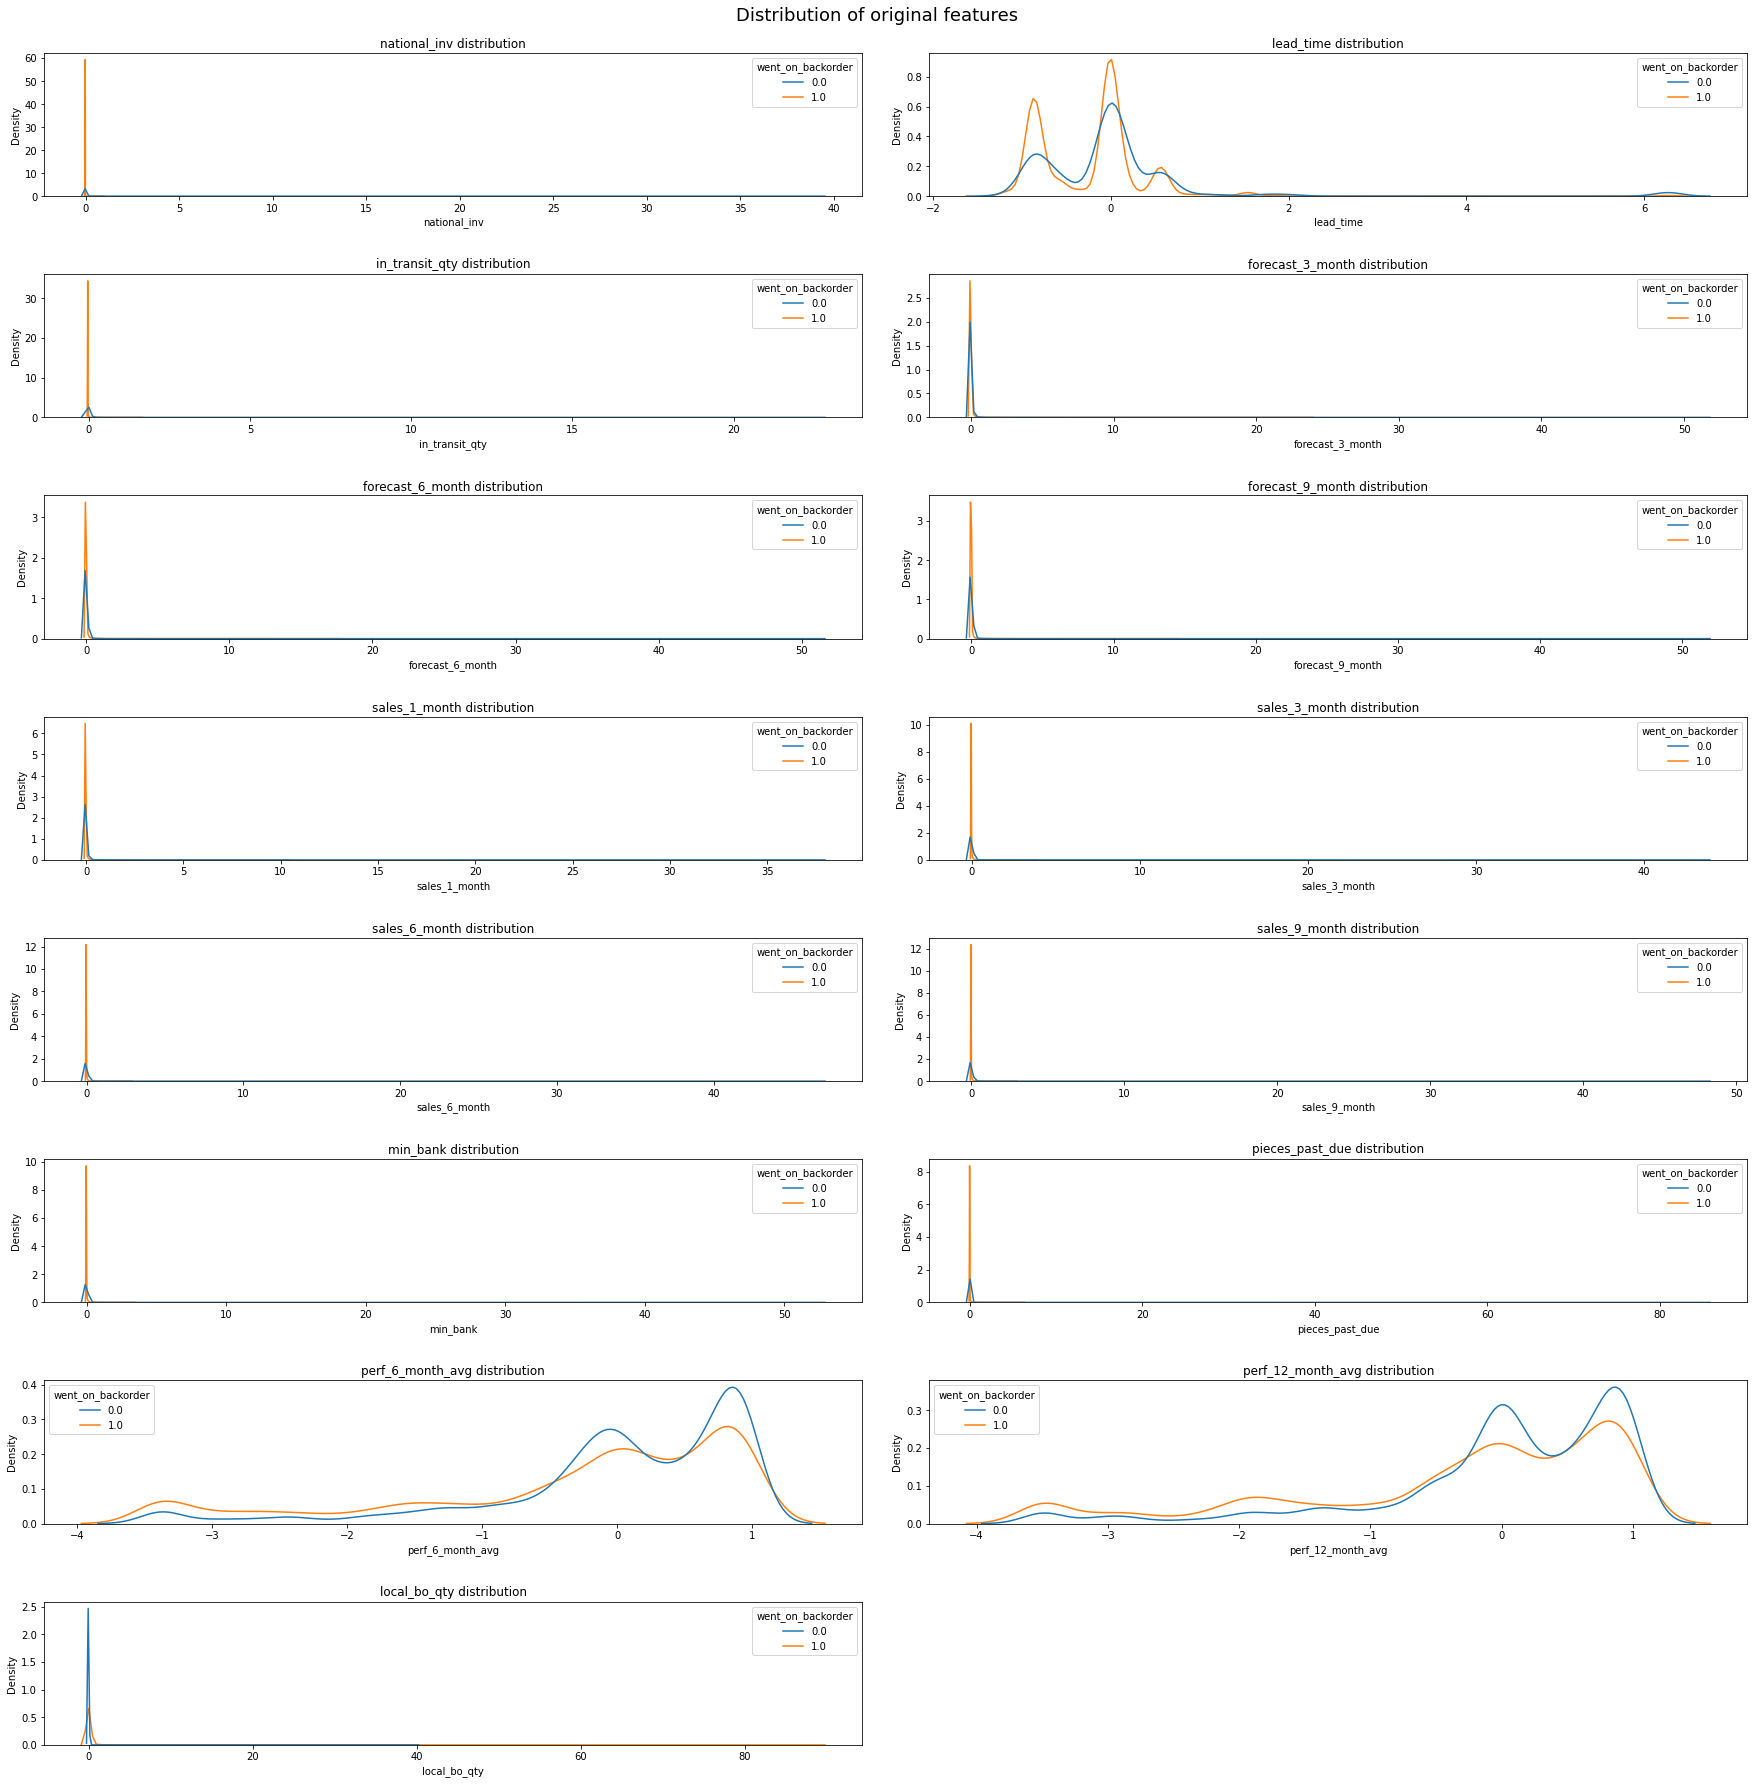

In [30]:
#Distribution of Standardized original features
fig = plt.figure(figsize=(25,25))
for i,j in enumerate(num_col_list):

  ax1=fig.add_subplot(8, 2, i+1)
  p=X_train_iter_trans[j]
  ax1.title.set_text(j+' distribution')
  sns.kdeplot(data = X_train_iter_trans_plt, x=num_col_list[i], hue='went_on_backorder')
fig.tight_layout(pad=3.0)
fig.suptitle("Distribution of original features", fontsize=18, y=1, x=.5)
plt.show()

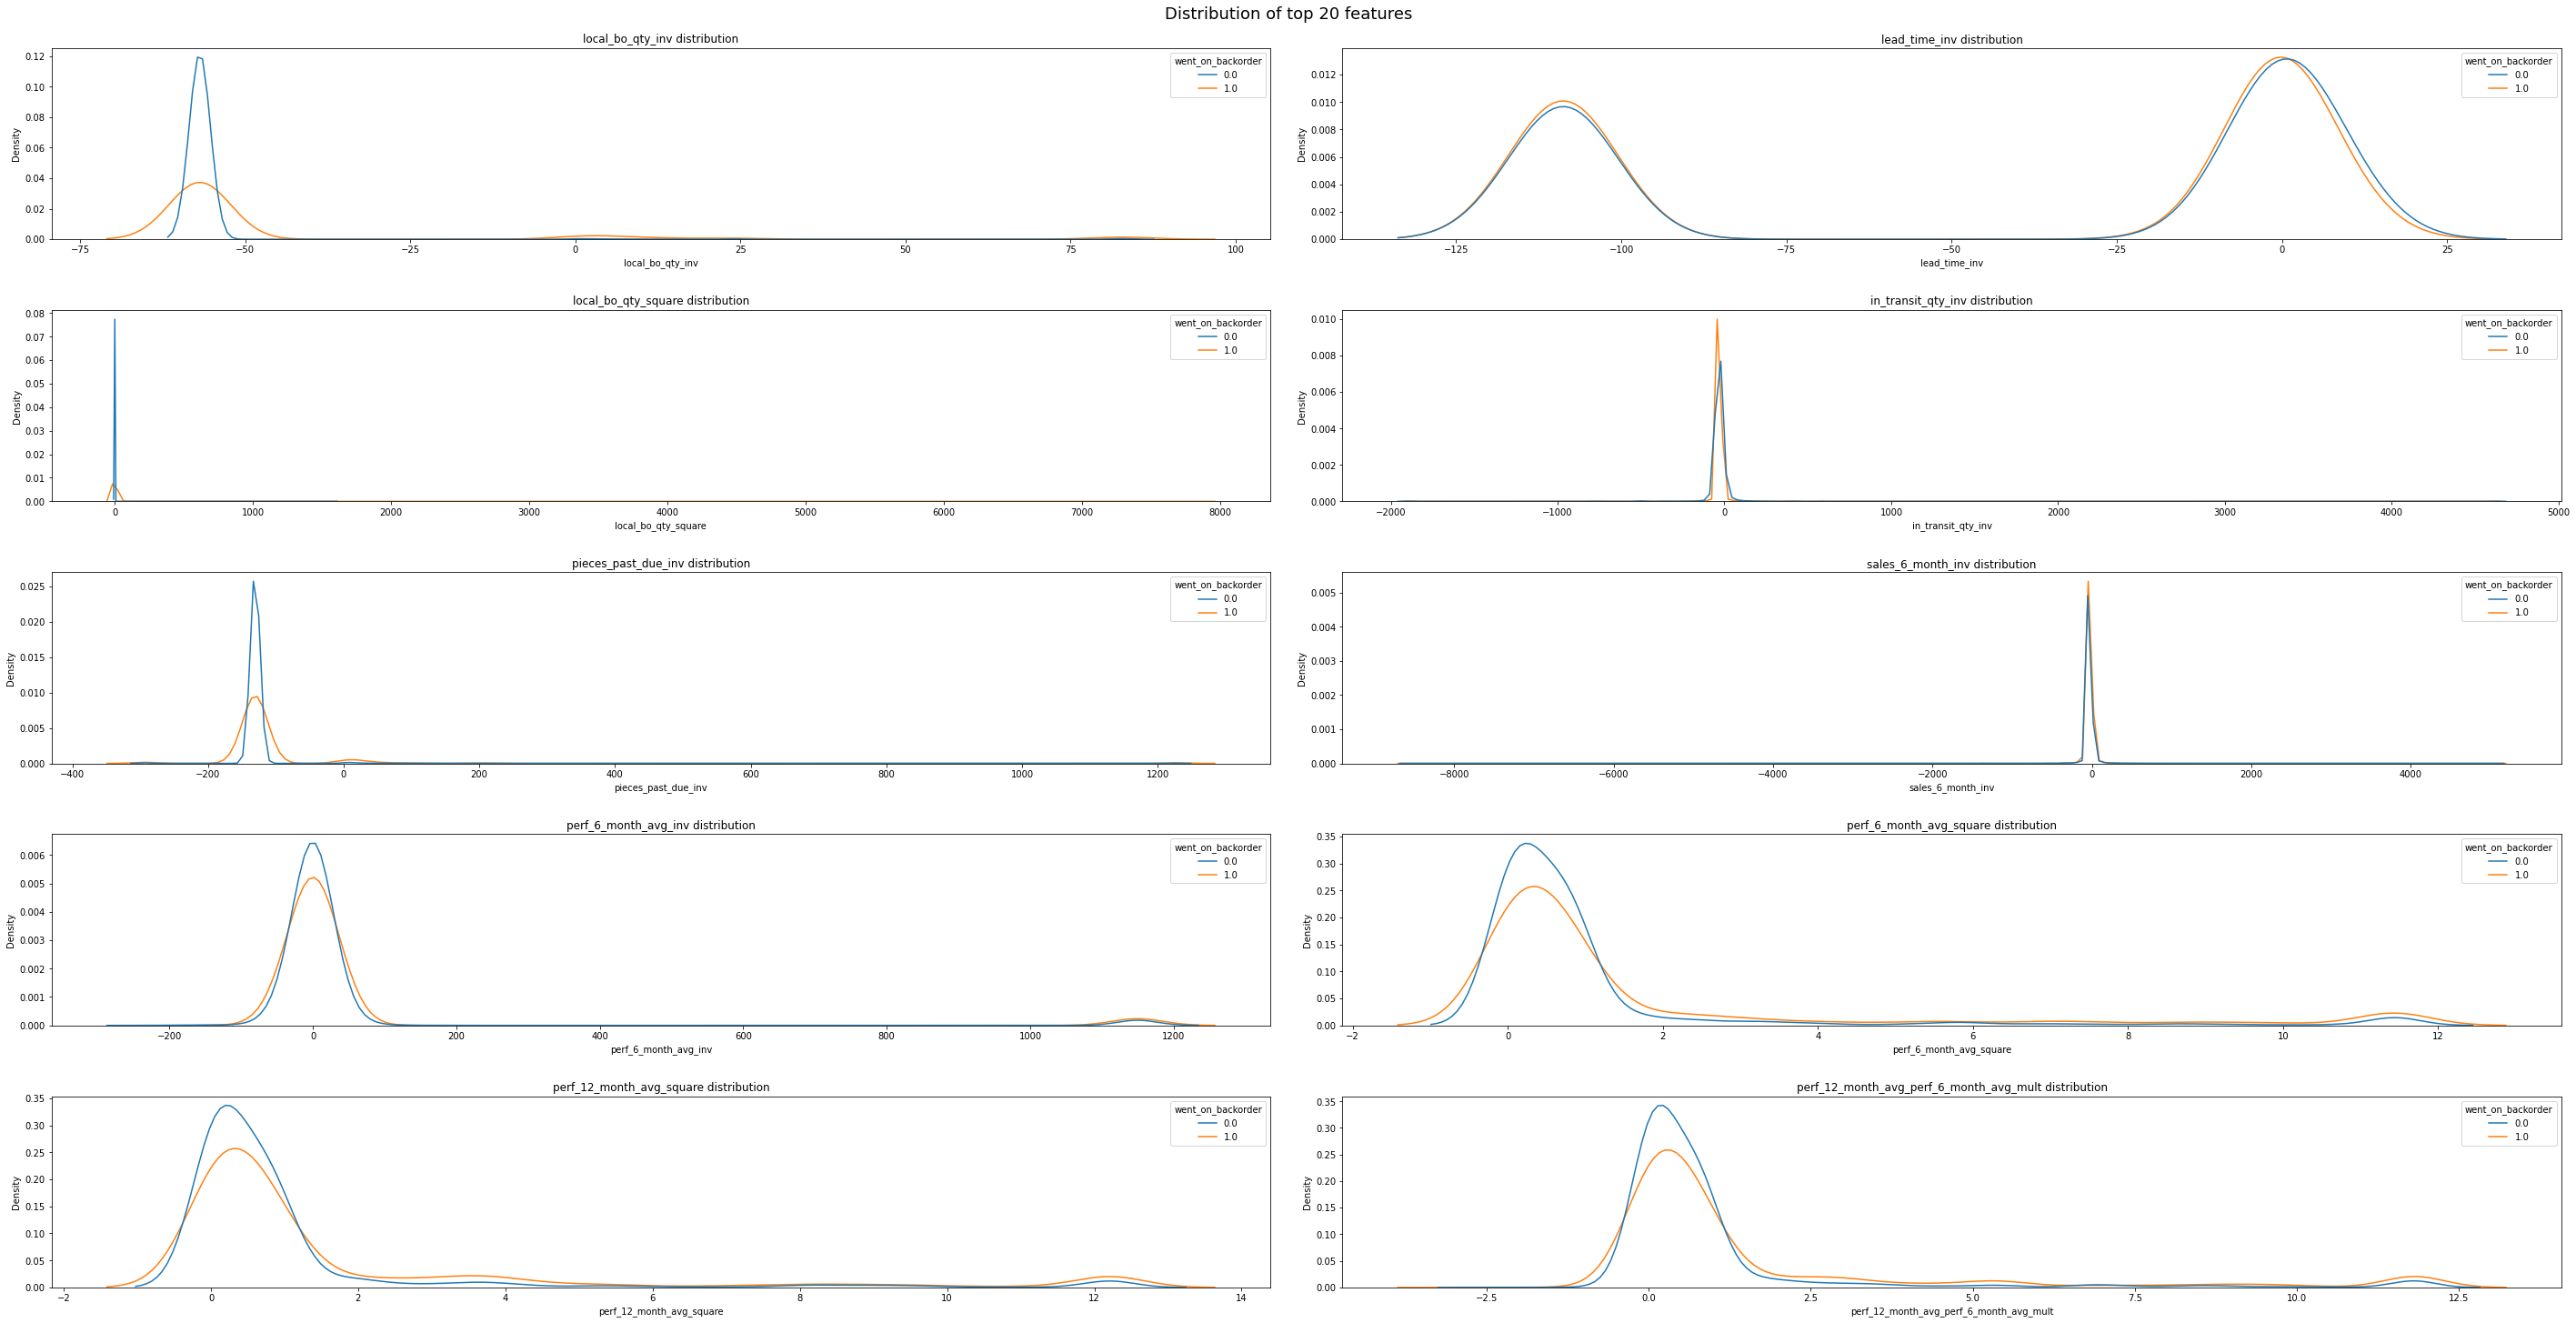

In [31]:
#Distribution of  newly created tranformed features
fig = plt.figure(figsize=(40,40))
for i,j in enumerate(sorted_idx[:10]):
  ax1=fig.add_subplot(10, 2, i+1)
  ax1.title.set_text(X_train_iter_trans_plt.columns[j]+' distribution')
  sns.kdeplot(data = X_train_iter_trans_plt, x=X_train_iter_trans_plt.columns[j], hue='went_on_backorder')
fig.tight_layout(pad=3.0)
fig.suptitle("Distribution of top 20 features", fontsize=18, y=1, x=.5)
plt.show()



* These newly created features are less skewed and now we are able to see some seperation between positve and negative points which will be helpful in classification

##Selecting best features based on Recursive Feature Selection

In [32]:
#Assigning remaning columns to train and test data

for cols in ['sku','potential_issue','deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop']:
  X_train_iter_trans[cols]=X_train_iter_under[cols]
  X_test_iter_trans[cols]=X_test_iter_stand[cols]


In [33]:
#Function to select best features iteratively based on roc_auc score
#Code referred from https://gist.github.com/rishabhrao1997/586d9d3d1c08adad80b2cf3abae2ba72#file-recursive_feature_selector-py

def best_feat(X_train,X_test,y_train,y_test,num_folds):
  
  roc_score = 1
  
  imp_cols=set()
  train_data=X_train
  target_train_data=y_train
  test_data=X_test
  target_test_data=y_test
  cols_list=list(train_data.columns)
  imp_cols_list=list(imp_cols)
  iter=1

  while (roc_score > 0.8) & (len(imp_cols_list)!=len(cols_list)):

    train_data_rem = train_data[train_data.columns[~train_data.columns.isin(imp_cols_list)]]
    Kfold = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 33)
    splits= Kfold.split(train_data_rem, target_train_data)
    model_feature_importance = np.zeros_like(train_data_rem.columns)
    roc_scores=[]

    print("\nIteration -",iter)
    print('*********************')

    #Performing K-Fold Cross validation
    for fold_num,(train_idx, val_idx) in enumerate(splits,1):
      print("Fold-",fold_num)

                 
      #defining the train and validation data
      x_train = train_data_rem.iloc[train_idx]
      x_val = train_data_rem.iloc[val_idx]
      y_train = target_train_data.iloc[train_idx]
      y_val = target_train_data.iloc[val_idx]
                
      #Implementing the XGB Classifier
      xg = XGBClassifier(n_jobs = -1, random_state = 33)
      xg.fit(x_train, y_train)

      #Adding the feature importance of each feature averaged over different folds
      model_feature_importance += (xg.feature_importances_)
      #ROC-AUC Score for each K-fold
      roc=roc_auc_score(y_val, xg.predict_proba(x_val)[:,1])
      print("ROC score at the end of Fold-{} is {}".format(fold_num,roc))
      roc_scores.append(roc)
    
    #Mean of the scores over K-folds
    roc_score=mean(roc_scores)
    print('\nROC score at the end of iteration {} is {}\n'.format(iter,roc_score))
    #Average feature importances
    model_feature_importance=model_feature_importance/num_folds
    
    #getting the non-zero feature important indices
    imp_cols_idx = np.where(np.abs(model_feature_importance) > 0)

    #getting the non-zero feature important column names
    imp_cols_names = x_train.columns[imp_cols_idx]

    print("")
            
    if roc_score > 0.8:
      imp_cols.update(imp_cols_names)
    
    imp_cols_list=list(imp_cols)
    
    print("\nNumber of features at the end of iteration {} is {}".format(iter,len(imp_cols_list)) )
    iter+=1

   
  train_data = train_data[imp_cols_list]
  test_data = test_data[imp_cols_list]

  return train_data, test_data


In [34]:
y_test=df_test['went_on_backorder']
y_test=pd.DataFrame(y_test,columns=['went_on_backorder'])
x_train,x_test=best_feat(X_train_iter_trans,X_test_iter_trans,y_train_iter_under,y_test,4)


Iteration - 1
*********************
Fold- 1
ROC score at the end of Fold-1 is 0.9554346179049272
Fold- 2
ROC score at the end of Fold-2 is 0.9571675878733873
Fold- 3
ROC score at the end of Fold-3 is 0.9535408815472418
Fold- 4
ROC score at the end of Fold-4 is 0.9572044271230362

ROC score at the end of iteration 1 is 0.9558368786121482



Number of features at the end of iteration 1 is 226

Iteration - 2
*********************
Fold- 1
ROC score at the end of Fold-1 is 0.9481188391791828
Fold- 2
ROC score at the end of Fold-2 is 0.9494394361773333
Fold- 3
ROC score at the end of Fold-3 is 0.9450288725688198
Fold- 4
ROC score at the end of Fold-4 is 0.9503008973528386

ROC score at the end of iteration 2 is 0.9482220113195436



Number of features at the end of iteration 2 is 434

Iteration - 3
*********************
Fold- 1
ROC score at the end of Fold-1 is 0.9437101174187347
Fold- 2
ROC score at the end of Fold-2 is 0.9448392353783519
Fold- 3
ROC score at the end of Fold-3 is 0.9417729

##Custom Stacking Classifier

In [35]:
class Custom_Stacking_Classifier:

  def __init__(self, models, metamodel, metamodel_params, row_per=0.70, col_per=0.70, base_models_cnt=7):
    self.row_per = row_per
    self.col_per = col_per
    self.base_models_cnt = base_models_cnt
    self.metamodel = metamodel
    self.models = models
    self.params = metamodel_params
    self.l_input=[]
    self.l_output=[]
    self.l_rows_idx=[]
    self.l_cols_idx=[]
    self.base_models=self.models.copy()
    self.base_models=(random.choices(self.base_models, k=self.base_models_cnt))

  def generating_samples(self,input_data, target_data):

    samp_col_min=20
    rows_len=input_data.shape[0]
    cols_len=input_data.shape[1]
    rows_idx=range(rows_len)
    cols_idx=range(cols_len)

    #Row sample length
    samp_row_len=round(self.row_per*rows_len)
    samp_row_rem_len=rows_len-samp_row_len

    #Column sample length
    col_samp_len=round(self.col_per*(input_data.shape[1]))


    #Sample row indices
    sample_row_idx=random.sample(rows_idx,samp_row_len)
    

    #Replicating row indices
    replicating_row_idx=random.sample(sample_row_idx,samp_row_rem_len)



    #Sample column indices
    k=np.random.randint(samp_col_min,cols_len)
    sample_col_idx=random.sample(cols_idx,k)
    


    #Sample data
    sample_data=input_data[sample_row_idx][:, sample_col_idx]
    target_sample_data=target_data[sample_row_idx]
    


    #Replicating data
    Replicated_sample_data=input_data[replicating_row_idx][:, sample_col_idx]
    target_replicated_sample_data=target_data[replicating_row_idx]
    


    #Concatenating data
 
    final_sample_data=np.vstack((sample_data,Replicated_sample_data))
    final_target_data=np.vstack((target_sample_data.reshape(-1,1),target_replicated_sample_data.reshape(-1,1)))



    return final_sample_data,final_target_data,sample_row_idx,sample_col_idx
  

  #Function will output predictions from base models
  def base_models_pred(self,data):
    
    #Train base models on first half train dataset
    row=data.shape[0]
    col=self.base_models_cnt
    base_model_out = np.zeros(shape=(row,col))
    for idx in range(self.base_models_cnt):
      with open(self.trn_bs_models[idx], 'rb') as file:
        model = pickle.load(file)
      col_index = self.l_cols_idx[idx]
      data_res=data[:,col_index]
      base_model_out[:,idx]+=(model.predict(data_res))
      

    return base_model_out


  #Function for training base and metadata models
  def models_train(self,input_data, target_data):

    #Train Test Split (50-50)
    D1, D2, T1, T2 = train_test_split(input_data, target_data, stratify=target_data, test_size=0.50, random_state=42)
    

    #Generating samples for first half train dataset

    for i in range(self.base_models_cnt):
      a,b,c,d=self.generating_samples(D1,T1)
      self.l_input.append(a)
      self.l_output.append(b)
      self.l_rows_idx.append(c)
      self.l_cols_idx.append(d)
    
    self.trn_bs_models=[]
    for idx in range(self.base_models_cnt):
      filename = 'bs_mod'+str(idx+1)+'.pkl'
      model=self.base_models[idx]
      model.fit(self.l_input[idx],self.l_output[idx])
      self.trn_bs_models.append(filename)
      with open(filename, 'wb') as file:
        pickle.dump(model, file)

    #Output predictions on second half train dataset
    output=self.base_models_pred(D2)
    


    #Train the metadata model on second half train dataset
    self.KFold = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
    self.gcv = GridSearchCV(self.metamodel, self.params, cv=self.KFold, scoring='f1', verbose=0, n_jobs=-1) 
    self.gcv.fit(output, T2)

  #Function to predict on test data
  def final_predict(self,test_data):

    ## Final prediction on Test data
    output = self.base_models_pred(test_data)
    y_proba = self.gcv.best_estimator_.predict_proba(output)[:,1].reshape(-1,1)
    y_pred= self.gcv.best_estimator_.predict(output)
    return y_pred,y_proba






In [51]:
X = x_train.values
y = y_train_iter_under.values
X_test = x_test.values

X_train, X_cv, y_train, y_cv = train_test_split(X, y, stratify=y, test_size=0.20, random_state=10)

## Using overfitted models
basemodels = [svm.SVC( C= 1000, probability=True),DecisionTreeClassifier(criterion= 'gini',max_depth= 9), RandomForestClassifier(max_depth=120,n_estimators= 200, random_state=42),KNeighborsClassifier(n_neighbors=3),XGBClassifier(n_estimators = 500,max_depth= 10, n_jobs=-1)]

metamodel = RandomForestClassifier()
params =  {'n_estimators':[10,20,30,40,50],'max_depth':[10,20,30,50,80,100], 'max_features':[3,5,7,10]}



In [52]:
clf = Custom_Stacking_Classifier(models = basemodels, metamodel = metamodel, metamodel_params=params, row_per=0.70, col_per=0.70, base_models_cnt=20)
clf.models_train(X_train, y_train)
y_pred_tr,y_prob_tr   = clf.final_predict(X_train)
y_pred_cv,y_prob_cv   = clf.final_predict(X_cv)
y_pred_test,y_prob_test = clf.final_predict(X_test)



In [53]:
x = PrettyTable()
x.field_names = ['Data',  "Model", "AUROC", "F2 Score", "Recall", "Precision"]

print("Calculating scores for Train data\n")
f2=fbeta_score(y_train,y_pred_tr, pos_label = 1,average='weighted', beta=2)
rc= recall_score(y_train, y_pred_tr)

roc_auc = roc_auc_score(y_train, y_prob_tr)
roc_auc_sc= roc_auc

average_precision = average_precision_score(y_train, y_prob_tr)
ps= average_precision

x.add_row(['Train', 'CustomStackingClassifier', roc_auc_sc, f2, rc, ps])

print("Calculating scores for cv data\n")
f2=fbeta_score(y_cv,y_pred_cv, pos_label = 1,average='weighted', beta=2)
rc= recall_score(y_cv, y_pred_cv)

roc_auc = roc_auc_score(y_cv, y_prob_cv)
roc_auc_sc= roc_auc

average_precision = average_precision_score(y_cv, y_prob_cv)
ps= average_precision

x.add_row(['Cv', 'CustomStackingClassifier', roc_auc_sc, f2, rc, ps])


print("Calculating scores for Test data\n")

f2=fbeta_score(y_test,y_pred_test, pos_label = 1,average='weighted', beta=2)
rc= recall_score(y_test, y_pred_test)

roc_auc = roc_auc_score(y_test, y_prob_test)
roc_auc_sc= roc_auc

average_precision = average_precision_score(y_test, y_prob_test)
avg_pr= round(average_precision,2)

x.add_row(['Test', 'CustomStackingClassifier', roc_auc_sc, f2, rc, ps])

print('\n')
print(x)

Calculating scores for Train data

Calculating scores for cv data

Calculating scores for Test data



+-------+--------------------------+--------------------+--------------------+--------------------+--------------------+
|  Data |          Model           |       AUROC        |      F2 Score      |       Recall       |     Precision      |
+-------+--------------------------+--------------------+--------------------+--------------------+--------------------+
| Train | CustomStackingClassifier | 0.9802781061425929 | 0.9556024962537663 | 0.9718839938011955 | 0.9723027832851974 |
|   Cv  | CustomStackingClassifier | 0.9501400232526194 | 0.9079743728244923 | 0.934041611332448  | 0.928000299646988  |
|  Test | CustomStackingClassifier | 0.9072935671371043 | 0.9474521169204233 | 0.6834077380952381 | 0.928000299646988  |
+-------+--------------------------+--------------------+--------------------+--------------------+--------------------+


* The results are very much similiar to what we obtained from individual models